In [1]:
library(tidyverse)
library(timetk)
library(lubridate)
library(cowplot)
library(prophet)
library(CausalImpact)
library(bsts)
library(forecast)
library(zoo)
library(lmtest)
library(xtable)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date


********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************


Attaching package: ‘cowplot’

The following object is masked from ‘package:lubridate’:

    stamp

Loading required package: Rcpp
Loading required package: rlang

Attaching package: ‘rlang’

The following objects are masked from ‘package:purr

In [2]:
options(mc.cores = parallel::detectCores())

In [3]:
basedir <- "../data/"

In [4]:
.start <- as_date("2003-01-01")

In [5]:
len <- 7
nperiod <- 40

# Load data

In [6]:
usa_infile <- str_c(basedir, "MSDX_day_20180922_newborn_geo_sex_mother.txt")

In [7]:
dat <- 
    readr::read_delim(
        file = usa_infile,
        delim = "\t",
        col_names = c(
            "Newborn", 
            "Birthday",
            "FIPS", 
            "MSA", 
            "Sex",
            "Mother"
        ),
        col_types = "cicccc"
    ) %>%
    dplyr::filter(FIPS != "00000") %>%
    dplyr::mutate(
        Birthdate = .start + Birthday - 1
    ) %>%
    dplyr::select(
        Newborn, Mother, Sex, Birthdate, Birthday, FIPS
    )

In [8]:
dat

Newborn,Mother,Sex,Birthdate,Birthday,FIPS
<chr>,<chr>,<chr>,<date>,<int>,<chr>
000003790,000003789,M,2006-02-24,1151,26087
000010647,000010644,M,2007-09-17,1721,17089
000010870,000010865,F,2005-09-28,1002,39023
000010918,000010916,F,2004-05-05,491,34007
000011972,000011971,M,2005-06-11,893,17197
000012016,000012015,F,2004-04-28,484,39023
000012337,000012336,M,2007-03-28,1548,39113
000012605,000012603,F,2006-09-28,1367,18003
000013055,000013053,M,2003-10-04,277,18097


# Analyse data

### Utils

In [9]:
plot_pred <- function(pred, .period, .title, ...) { 
    pred %>%
        ggplot(
            mapping = aes(x = period, y = y)
        ) +
        # All points
        geom_point(size = 0.5, alpha = 0.8) +
        # Fetal death
        geom_point(
            data = dplyr::filter(
                pred,
                period >= .period & period <= .period + 19
            ),
            size = 1.5,
            colour = "red",
            alpha = 0.75
        ) +
        # Reduced conceptions
        geom_point(
            data = dplyr::filter(
                pred,
                period >= .period + 28 & period <= .period + 39
            ),
            size = 1.5,
            colour = "purple",
            alpha = 0.75
        ) +
        # Line plot
        geom_line(alpha = 0.8, size = 0.333) +
        # Vertical line at intervention
        geom_vline(
            xintercept = .period,
            linetype = "dashed",
            size = 0.5
        ) +
        # Forecast
        geom_line(
            data = dplyr::filter(
                pred,
                period >= .period
            ),
            mapping = aes(y = yhat),
            colour = "#0072B2",
            na.rm = TRUE,
        ) +
        # Confidence intervals
        geom_ribbon(
            data = dplyr::filter(
                pred,
                period >= .period
            ),
            mapping = aes(ymin = yhat_lower, ymax = yhat_upper),
            fill = "#0072B2",
            na.rm = TRUE,
            alpha = 0.2
        ) +
        # Axes
        scale_x_continuous(
            breaks = seq(from = 1, to = .period + 39, by = 16),
        ) +
        # Title and labels
        labs(x = "Period", y = "SRB", title = .title) +
        # Themes
        theme_cowplot(font_size = 12, font_family = "serif") +
        background_grid(minor = "xy") +
        theme(
            aspect.ratio = 0.4,
            ...
        )
}

In [10]:
add_periods <- function(df, start, intv, len, nperiod, ...){
    # Remove irrelevant births 
    if(nperiod){
        df_out <- 
            df %>%
            dplyr::filter(
                Birthdate <= intv + len * nperiod - 1
            )
    } else {
        df_out <- df
    }
    
    # Get periods
    intv_day <- as.integer(intv - start + 1)
    residual <- intv_day %% len
    cat(sprintf("Intervention on day %d.\n", intv_day))
    cat(sprintf("Residual = %d.\n", residual))
    
    df_out <-
        df_out %>%
        mutate(
            day_in_period = (Birthday - residual) %% len + 1,
            period = (Birthday - residual) %/% len + ifelse(residual <= 1, 0, 1) + 1,
            period_start = Birthdate - day_in_period + 1,
            period_end = period_start + len - 1,
        )    
    
    intv_period <-
        df_out %>%
        dplyr::distinct(period_start, period) %>%
        dplyr::filter(
            period_start == intv
        ) %>%
        pull(period)
        
    invisible(list(df = df_out, intv_period = intv_period))
}

In [11]:
get_summarised_data <- function(df) {
    df_out <-
        df %>%
        # Group by period and sum, and then get count
        dplyr::group_by(period, period_start, period_end, Sex) %>%
        dplyr::summarize(Count = n()) %>%
        dplyr::ungroup() %>%
        # Group by period, and then sum (by sex)
        dplyr::group_by(period, period_start, period_end) %>% 
        dplyr::mutate(Sum = sum(Count)) %>% 
        # SRB = M / (M + F)
        dplyr::filter(Sex == "M") %>% 
        dplyr::mutate(y = Count / Sum) %>%
        dplyr::ungroup() %>%
        dplyr::select(-Sex)
}

In [12]:
fit_arima <- function(df, .period = NULL, ...){
    df_train <-
        df %>%
        dplyr::filter(period < .period) %>%
        dplyr::select(y)
    
    fit <- 
        df_train %>%
        auto.arima(...)
}

In [13]:
get_arima_forecasts <- function(fit, df, ...){
    pred <-
        fit %>%
        forecast(
            ...,
        ) %>%
        timetk::tk_tbl() %>%
        dplyr::rename(
            period = index,
            yhat = `Point Forecast`,
            yhat_lower = `Lo 95`,
            yhat_upper = `Hi 95`
        ) %>%
        full_join(x = df, y = .)
}

In [14]:
get_ssm_causal <- function(df, .intv, niter = 2000){
    # Preintervention TS
    y <-
        df %>%
        mutate(
            y = ifelse(period >= .intv, NA, y)
        ) %>%
        pull(y) %>%
        zoo(x = ., order.by = pull(df, period))
    
    # Seasonality and holidays
    ss <- NULL
    ss <- AddLocalLevel(list(), y) # state vectors
    ss <- AddSeasonal(ss, y, nseasons = 4, season.duration = 12)
    
    # Fit model
    .bsts_model <-
        bsts(y, state.specification = ss, niter = niter)
    
    invisible(list(data = y, model = .bsts_model))
}

## Hurricane Katrina (30 August, 2005)

In [15]:
.katrina <- as_date("2005-08-30")

In [16]:
dat_katrina_wk_all <- 
    dat %>%
    add_periods(
        start = .start, intv = `.katrina`, len = len, nperiod = nperiod
    )

Intervention on day 973.
Residual = 0.


In [17]:
dat_katrina_wk_all$intv_period

[1] 140

In [19]:
df_katrina_wk_all <- 
    dat_katrina_wk_all$df %>%
    get_summarised_data()

In [20]:
df_katrina_wk_all

period,period_start,period_end,Count,Sum,y
<dbl>,<date>,<date>,<int>,<int>,<dbl>
1,2002-12-31,2003-01-06,665,1307,0.5087988
2,2003-01-07,2003-01-13,943,1846,0.5108342
3,2003-01-14,2003-01-20,1024,1935,0.5291990
4,2003-01-21,2003-01-27,974,1864,0.5225322
5,2003-01-28,2003-02-03,1011,1863,0.5426731
6,2003-02-04,2003-02-10,961,1905,0.5044619
7,2003-02-11,2003-02-17,1014,1946,0.5210689
8,2003-02-18,2003-02-24,1010,1925,0.5246753
9,2003-02-25,2003-03-03,1046,2060,0.5077670


In [21]:
df_katrina_wk_all %>%
    write_delim(
        path = str_c(basedir, "ts_katrina_wk_all.tsv"),
        delim = "\t"
    )

### All states

#### ARIMA

In [20]:
arima_katrina_wk_all <-
    df_katrina_wk_all %>%
    fit_arima(
        .period = dat_katrina_wk_all$intv_period,
        seasonal = TRUE,
        allowmean = TRUE,
        ic = "bic",
        nmodels = 500,
        max.order = 48,
        max.D = 12, 
        stepwise = TRUE,
        parallel = TRUE
    )

Warning message in auto.arima(., ...):
“Parallel computer is only implemented when stepwise=FALSE, the model will be fit in serial.”

In [21]:
arima_katrina_wk_all

Series: . 
ARIMA(0,0,0) with non-zero mean 

Coefficients:
        mean
      0.5167
s.e.  0.0009

sigma^2 estimated as 0.0001071:  log likelihood=438.62
AIC=-873.23   AICc=-873.14   BIC=-867.36

In [22]:
resfit_arima_katrina_wk_all <-
    lm(formula = arima_katrina_wk_all$residuals ~ 1)

In [23]:
bg_arima_katrina_wk_all <-
    resfit_arima_katrina_wk_all %>%
    checkresiduals(lag = 13, test = "BG", plot = FALSE)

In [24]:
print(bg_arima_katrina_wk_all)


	Breusch-Godfrey test for serial correlation of order up to 13

data:  Residuals
LM test = 4.5265, df = 13, p-value = 0.9842



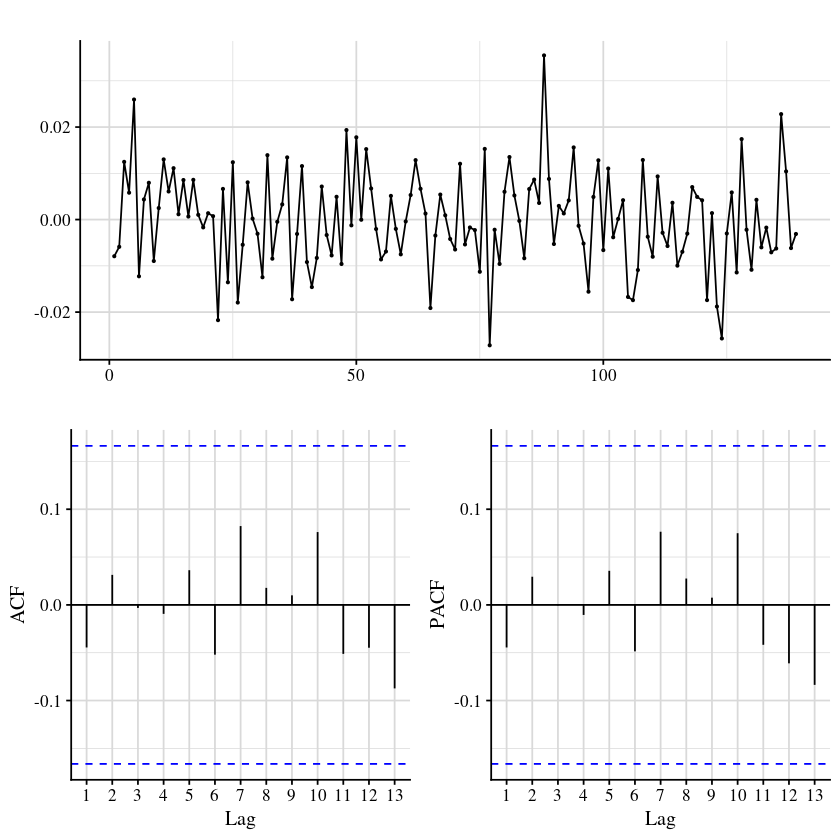

In [25]:
resfit_arima_katrina_wk_all %>%
    residuals() %>%
    ggtsdisplay(
        plot.type = c("partial"),
        lag.max = 13,
        theme = theme_cowplot(
            font_size = 12, font_family = 'serif'
        ) +
        background_grid(
            minor = 'xy'
        )
    )

In [26]:
pred_arima_katrina_wk_all <-
    arima_katrina_wk_all %>%
    get_arima_forecasts(
        df = df_katrina_wk_all,
        h = nperiod,
        level = 95
    )

Joining, by = "period"

In [27]:
pred_arima_katrina_wk_all

period,period_start,period_end,Count,Sum,y,yhat,yhat_lower,yhat_upper
<dbl>,<date>,<date>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,2002-12-31,2003-01-06,665,1307,0.5087988,NA,NA,NA
2,2003-01-07,2003-01-13,943,1846,0.5108342,NA,NA,NA
3,2003-01-14,2003-01-20,1024,1935,0.5291990,NA,NA,NA
4,2003-01-21,2003-01-27,974,1864,0.5225322,NA,NA,NA
5,2003-01-28,2003-02-03,1011,1863,0.5426731,NA,NA,NA
6,2003-02-04,2003-02-10,961,1905,0.5044619,NA,NA,NA
7,2003-02-11,2003-02-17,1014,1946,0.5210689,NA,NA,NA
8,2003-02-18,2003-02-24,1010,1925,0.5246753,NA,NA,NA
9,2003-02-25,2003-03-03,1046,2060,0.5077670,NA,NA,NA


In [28]:
pred_arima_katrina_wk_all %>%
    dplyr::filter(
        period >= dat_katrina_wk_all$intv_period
    ) %>%
    dplyr::select(
        Period = period, SRB = y,
        `Lower 95%` = yhat_lower, `Upper 95%` = yhat_upper
    ) %>%
    xtable(
        auto = TRUE, digits = 4,
        caption = "10 period out-of-sample forecasts for Hurricane Katrina in all states"
    ) %>%
    print(
        include.rownames = FALSE,
        booktabs = TRUE
    )

% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Wed Apr  1 15:23:02 2020
\begin{table}[ht]
\centering
\begin{tabular}{rrrr}
  \toprule
Period & SRB & Lower 95\% & Upper 95\% \\ 
  \midrule
  140 & 0.5192 & 0.4964 & 0.5370 \\ 
    141 & 0.5186 & 0.4964 & 0.5370 \\ 
    142 & 0.5275 & 0.4964 & 0.5370 \\ 
    143 & 0.5117 & 0.4964 & 0.5370 \\ 
    144 & 0.5140 & 0.4964 & 0.5370 \\ 
    145 & 0.5304 & 0.4964 & 0.5370 \\ 
    146 & 0.5157 & 0.4964 & 0.5370 \\ 
    147 & 0.5147 & 0.4964 & 0.5370 \\ 
    148 & 0.5222 & 0.4964 & 0.5370 \\ 
    149 & 0.5090 & 0.4964 & 0.5370 \\ 
    150 & 0.5045 & 0.4964 & 0.5370 \\ 
    151 & 0.5121 & 0.4964 & 0.5370 \\ 
    152 & 0.5192 & 0.4964 & 0.5370 \\ 
    153 & 0.5106 & 0.4964 & 0.5370 \\ 
    154 & 0.5187 & 0.4964 & 0.5370 \\ 
    155 & 0.5100 & 0.4964 & 0.5370 \\ 
    156 & 0.5246 & 0.4964 & 0.5370 \\ 
    157 & 0.5308 & 0.4964 & 0.5370 \\ 
    158 & 0.5128 & 0.4964 & 0.5370 \\ 
    159 & 0.5177 & 0.4964 & 0.5370 \\ 
    160 & 0.5061 & 0

In [29]:
p_arima_katrina_wk_all <-
    pred_arima_katrina_wk_all %>%
    plot_pred(
        .period = dat_katrina_wk_all$intv_period,
        .title = "Katrina (all states)"
    ) +
    labs(subtitle = "ARIMA")

In [30]:
p_arima_katrina_wk_all %>%
    cowplot::save_plot(
        filename = str_c(basedir, "plots/time_series/", "ts_wk_katrina_arima_all_states.pdf")
    )

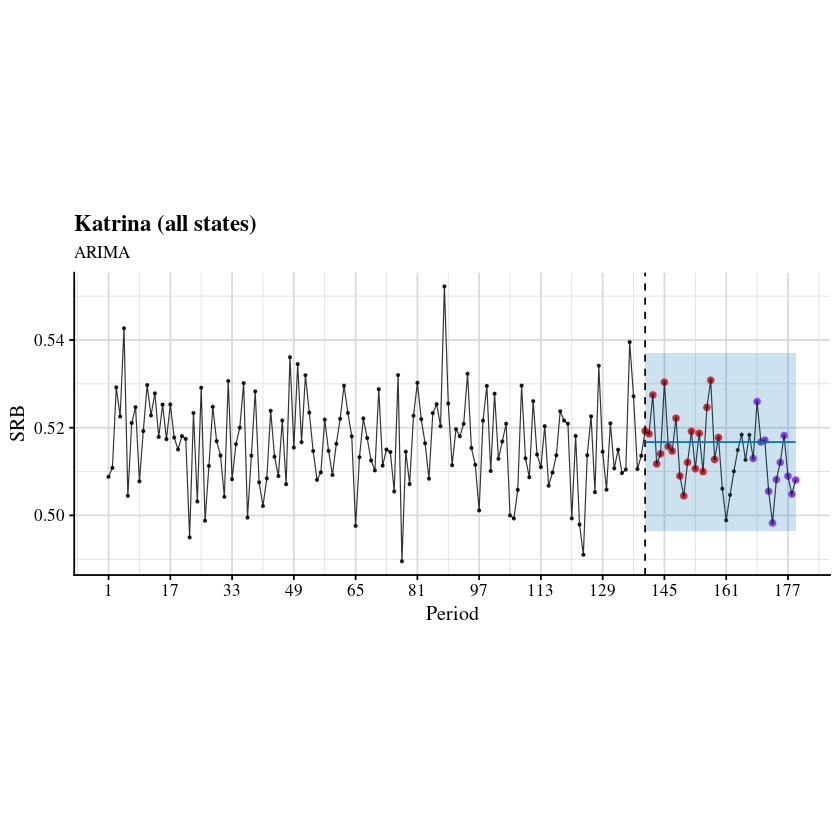

In [31]:
p_arima_katrina_wk_all

#### CausalImpact

In [32]:
bsts_katrina_wk_all <-
    df_katrina_wk_all %>%
    get_ssm_causal(
        .intv = dat_katrina_wk_all$intv_period
    )

=-=-=-=-= Iteration 0 Wed Apr  1 15:23:04 2020 =-=-=-=-=
=-=-=-=-= Iteration 200 Wed Apr  1 15:23:04 2020 =-=-=-=-=
=-=-=-=-= Iteration 400 Wed Apr  1 15:23:05 2020 =-=-=-=-=
=-=-=-=-= Iteration 600 Wed Apr  1 15:23:05 2020 =-=-=-=-=
=-=-=-=-= Iteration 800 Wed Apr  1 15:23:05 2020 =-=-=-=-=
=-=-=-=-= Iteration 1000 Wed Apr  1 15:23:06 2020 =-=-=-=-=
=-=-=-=-= Iteration 1200 Wed Apr  1 15:23:06 2020 =-=-=-=-=
=-=-=-=-= Iteration 1400 Wed Apr  1 15:23:06 2020 =-=-=-=-=
=-=-=-=-= Iteration 1600 Wed Apr  1 15:23:07 2020 =-=-=-=-=
=-=-=-=-= Iteration 1800 Wed Apr  1 15:23:07 2020 =-=-=-=-=


In [33]:
causal_katrina_wk_all <-
    df_katrina_wk_all %>%
    dplyr::filter(
        period >= dat_katrina_wk_all$intv_period
    ) %>%
    dplyr::pull(y) %>%
    CausalImpact(
        bsts.model = bsts_katrina_wk_all$model,
        post.period.response = .
    )

In [34]:
df_causal_katrina_wk_all <-
    causal_katrina_wk_all$series %>%
    tk_tbl() %>%
    rowid_to_column(var = "Period")

Warning message in tk_tbl.zoo(.):
“Warning: No index to preserve. Object otherwise converted to tibble successfully.”

In [35]:
pred_causal_katrina_wk_all <-
    df_causal_katrina_wk_all %>%
    dplyr::select(
        period = Period,
        y = response,
        yhat = point.pred,
        yhat_lower = point.pred.lower,
        yhat_upper = point.pred.upper
    ) 

In [36]:
pred_causal_katrina_wk_all %>%
    dplyr::filter(period >= dat_katrina_wk_all$intv_period) %>%
    dplyr::select(
        Period = period, SRB = y,
        `Lower 95%` = yhat_lower, `Upper 95%` = yhat_upper
    ) %>%
    xtable(
        auto = TRUE,
        align = "llrrr",
        digits = 4,
        caption = "10 period out-of-sample forecasts for Hurricane Katrina in all states"
    ) %>%
    print(
        include.rownames = FALSE,
        booktabs = TRUE
    )

% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Wed Apr  1 15:23:07 2020
\begin{table}[ht]
\centering
\begin{tabular}{lrrr}
  \toprule
Period & SRB & Lower 95\% & Upper 95\% \\ 
  \midrule
  140 & 0.5192 & 0.4965 & 0.5395 \\ 
    141 & 0.5186 & 0.4972 & 0.5385 \\ 
    142 & 0.5275 & 0.4972 & 0.5401 \\ 
    143 & 0.5117 & 0.4961 & 0.5384 \\ 
    144 & 0.5140 & 0.4981 & 0.5403 \\ 
    145 & 0.5304 & 0.4954 & 0.5384 \\ 
    146 & 0.5157 & 0.4939 & 0.5390 \\ 
    147 & 0.5147 & 0.4942 & 0.5377 \\ 
    148 & 0.5222 & 0.4943 & 0.5382 \\ 
    149 & 0.5090 & 0.4934 & 0.5383 \\ 
    150 & 0.5045 & 0.4938 & 0.5384 \\ 
    151 & 0.5121 & 0.4933 & 0.5381 \\ 
    152 & 0.5192 & 0.4941 & 0.5387 \\ 
    153 & 0.5106 & 0.4931 & 0.5388 \\ 
    154 & 0.5187 & 0.4947 & 0.5377 \\ 
    155 & 0.5100 & 0.4953 & 0.5386 \\ 
    156 & 0.5246 & 0.4945 & 0.5381 \\ 
    157 & 0.5308 & 0.4940 & 0.5381 \\ 
    158 & 0.5128 & 0.4935 & 0.5385 \\ 
    159 & 0.5177 & 0.4937 & 0.5395 \\ 
    160 & 0.5061 & 0

In [37]:
p_causal_katrina_wk_all <-
    pred_causal_katrina_wk_all %>%
    plot_pred(
        .period = dat_katrina_wk_all$intv_period,
        .title = "Hurricane Katrina (all states)"
    ) +
    labs(subtitle = "SSM")

In [38]:
p_causal_katrina_wk_all %>%
    cowplot::save_plot(
        filename = str_c(basedir, "plots/time_series/", "ts_wk_katrina_ssm_all_states.pdf")
    )

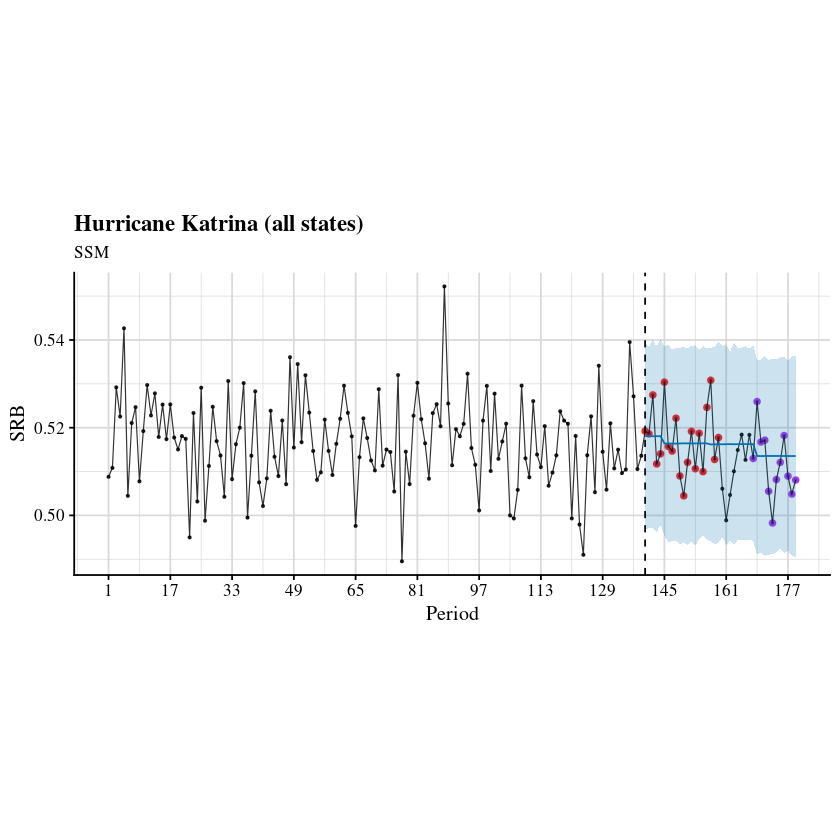

In [39]:
p_causal_katrina_wk_all

### LA and MS only

In [40]:
fips_lams <-
    read_table(
        file = str_c(basedir, "regression/FIPS_LA_MS.csv"), col_names = FALSE
    ) %>%
    pull()

Parsed with column specification:
cols(
  X1 = col_double()
)


In [41]:
dat_katrina_wk_lams <-
    list(
        df = dat_katrina_wk_all$df %>%
             dplyr::filter(FIPS %in% fips_lams),
        intv_period = dat_katrina_wk_all$intv_period
    )

In [42]:
df_katrina_wk_lams <-
    dat_katrina_wk_lams$df %>%
    get_summarised_data()

In [43]:
arima_katrina_wk_lams <-
    df_katrina_wk_lams %>%
    fit_arima(
        .period = dat_katrina_wk_lams$intv_period,
        seasonal = TRUE,
        allowmean = TRUE,
        ic = "bic",
        nmodels = 500,
        max.order = 48,
        max.D = 12,
        stepwise = TRUE,
        parallel = TRUE
    )

Warning message in auto.arima(., ...):
“Parallel computer is only implemented when stepwise=FALSE, the model will be fit in serial.”

In [44]:
arima_katrina_wk_lams

Series: . 
ARIMA(0,0,0) with non-zero mean 

Coefficients:
        mean
      0.5283
s.e.  0.0064

sigma^2 estimated as 0.005733:  log likelihood=161.99
AIC=-319.99   AICc=-319.9   BIC=-314.12

In [45]:
resfit_arima_katrina_wk_lams <-
    lm(formula = arima_katrina_wk_lams$residuals ~ 1)

In [46]:
bg_arima_katrina_wk_lams <-
    resfit_arima_katrina_wk_lams %>%
    checkresiduals(lag = 13, test = "BG", plot = FALSE)

In [47]:
print(bg_arima_katrina_wk_lams)


	Breusch-Godfrey test for serial correlation of order up to 13

data:  Residuals
LM test = 21.289, df = 13, p-value = 0.06741



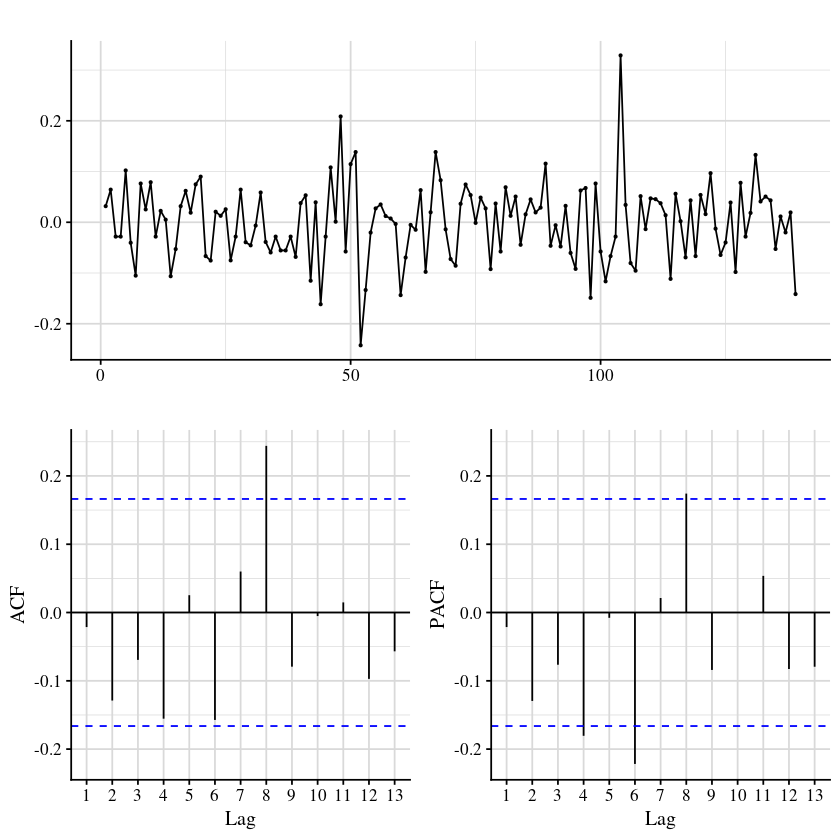

In [48]:
resfit_arima_katrina_wk_lams %>%
    residuals() %>%
    ggtsdisplay(
        plot.type = c("partial"),
        lag.max = 13,
        theme = theme_cowplot(
            font_size = 12, font_family = 'serif'
        ) +
        background_grid(
            minor = 'xy'
        )
    )

In [49]:
pred_arima_katrina_wk_lams <-
    arima_katrina_wk_lams %>%
    get_arima_forecasts(
        df = df_katrina_wk_lams,
        h = nperiod,
        level = 95
    )

Joining, by = "period"

In [50]:
pred_arima_katrina_wk_lams

period,period_start,period_end,Count,Sum,y,yhat,yhat_lower,yhat_upper
<dbl>,<date>,<date>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,2002-12-31,2003-01-06,14,25,0.5600000,NA,NA,NA
2,2003-01-07,2003-01-13,32,54,0.5925926,NA,NA,NA
3,2003-01-14,2003-01-20,32,64,0.5000000,NA,NA,NA
4,2003-01-21,2003-01-27,36,72,0.5000000,NA,NA,NA
5,2003-01-28,2003-02-03,29,46,0.6304348,NA,NA,NA
6,2003-02-04,2003-02-10,20,41,0.4878049,NA,NA,NA
7,2003-02-11,2003-02-17,22,52,0.4230769,NA,NA,NA
8,2003-02-18,2003-02-24,26,43,0.6046512,NA,NA,NA
9,2003-02-25,2003-03-03,31,56,0.5535714,NA,NA,NA


In [51]:
pred_arima_katrina_wk_lams %>%
    dplyr::filter(
        period >= dat_katrina_wk_all$intv_period
    ) %>%
    dplyr::select(
        Period = period, SRB = y,
        `Lower 95%` = yhat_lower, `Upper 95%` = yhat_upper
    ) %>%
    xtable(
        auto = TRUE, digits = 4,
        caption = "10 period out-of-sample forecasts for Hurricane Katrina in Louisiana and Mississippi"
    ) %>%
    print(
        include.rownames = FALSE,
        booktabs = TRUE
    )

% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Wed Apr  1 15:23:09 2020
\begin{table}[ht]
\centering
\begin{tabular}{rrrr}
  \toprule
Period & SRB & Lower 95\% & Upper 95\% \\ 
  \midrule
  140 & 0.4444 & 0.3799 & 0.6767 \\ 
    141 & 0.5060 & 0.3799 & 0.6767 \\ 
    142 & 0.5957 & 0.3799 & 0.6767 \\ 
    143 & 0.6197 & 0.3799 & 0.6767 \\ 
    144 & 0.4375 & 0.3799 & 0.6767 \\ 
    145 & 0.5246 & 0.3799 & 0.6767 \\ 
    146 & 0.5077 & 0.3799 & 0.6767 \\ 
    147 & 0.4706 & 0.3799 & 0.6767 \\ 
    148 & 0.6182 & 0.3799 & 0.6767 \\ 
    149 & 0.5385 & 0.3799 & 0.6767 \\ 
    150 & 0.5224 & 0.3799 & 0.6767 \\ 
    151 & 0.4615 & 0.3799 & 0.6767 \\ 
    152 & 0.6087 & 0.3799 & 0.6767 \\ 
    153 & 0.5484 & 0.3799 & 0.6767 \\ 
    154 & 0.6176 & 0.3799 & 0.6767 \\ 
    155 & 0.6471 & 0.3799 & 0.6767 \\ 
    156 & 0.4737 & 0.3799 & 0.6767 \\ 
    157 & 0.5714 & 0.3799 & 0.6767 \\ 
    158 & 0.5116 & 0.3799 & 0.6767 \\ 
    159 & 0.4933 & 0.3799 & 0.6767 \\ 
    160 & 0.5000 & 0

In [52]:
p_arima_katrina_wk_lams <-
    pred_arima_katrina_wk_lams %>%
    plot_pred(
        .period = dat_katrina_wk_lams$intv_period,
        .title = "Katrina (Louisiana and Mississippi)"
    ) +
    labs(subtitle = "ARIMA")

In [53]:
p_arima_katrina_wk_lams %>%
    cowplot::save_plot(
        filename = str_c(basedir, "plots/time_series/", "ts_wk_katrina_arima_lams.pdf")
    )

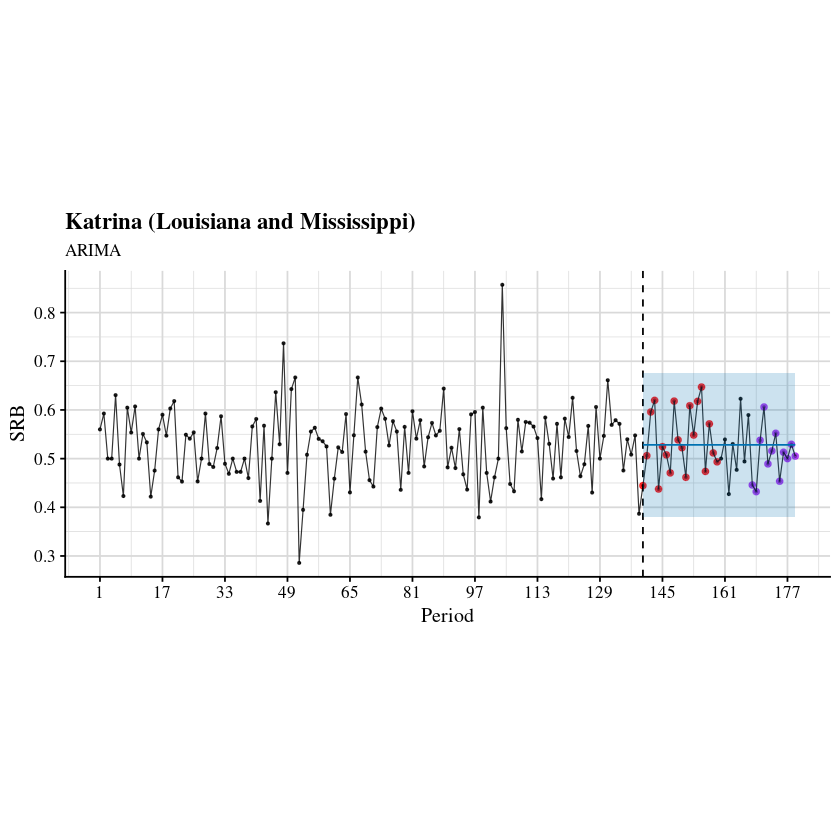

In [54]:
p_arima_katrina_wk_lams

#### CausalImpact

In [55]:
bsts_katrina_wk_lams <-
    df_katrina_wk_lams %>%
    get_ssm_causal(
        .intv = dat_katrina_wk_lams$intv_period
    )

=-=-=-=-= Iteration 0 Wed Apr  1 15:23:10 2020 =-=-=-=-=
=-=-=-=-= Iteration 200 Wed Apr  1 15:23:10 2020 =-=-=-=-=
=-=-=-=-= Iteration 400 Wed Apr  1 15:23:11 2020 =-=-=-=-=
=-=-=-=-= Iteration 600 Wed Apr  1 15:23:11 2020 =-=-=-=-=
=-=-=-=-= Iteration 800 Wed Apr  1 15:23:11 2020 =-=-=-=-=
=-=-=-=-= Iteration 1000 Wed Apr  1 15:23:12 2020 =-=-=-=-=
=-=-=-=-= Iteration 1200 Wed Apr  1 15:23:12 2020 =-=-=-=-=
=-=-=-=-= Iteration 1400 Wed Apr  1 15:23:12 2020 =-=-=-=-=
=-=-=-=-= Iteration 1600 Wed Apr  1 15:23:13 2020 =-=-=-=-=
=-=-=-=-= Iteration 1800 Wed Apr  1 15:23:13 2020 =-=-=-=-=


In [56]:
causal_katrina_wk_lams <-
    df_katrina_wk_lams %>%
    dplyr::filter(
        period >= dat_katrina_wk_lams$intv_period
    ) %>%
    dplyr::pull(y) %>%
    CausalImpact(
        bsts.model = bsts_katrina_wk_lams$model,
        post.period.response = .
    )

In [57]:
df_causal_katrina_wk_lams <-
    causal_katrina_wk_lams$series %>%
    tk_tbl() %>%
    rowid_to_column(var = "Period")

Warning message in tk_tbl.zoo(.):
“Warning: No index to preserve. Object otherwise converted to tibble successfully.”

In [58]:
pred_causal_katrina_wk_lams <-
    df_causal_katrina_wk_lams %>%
    dplyr::select(
        period = Period,
        y = response,
        yhat = point.pred,
        yhat_lower = point.pred.lower,
        yhat_upper = point.pred.upper
    ) 

In [59]:
pred_causal_katrina_wk_lams %>%
    dplyr::filter(period >= dat_katrina_wk_lams$intv_period) %>%
    dplyr::select(
        Period = period, SRB = y,
        `Lower 95%` = yhat_lower, `Upper 95%` = yhat_upper
    ) %>%
    xtable(
        auto = TRUE, digits = 4,
        caption = "10 period out-of-sample forecasts for Hurricane Katrina in Louisiana and Mississippi"
    ) %>%
    print(
        include.rownames = FALSE,
        booktabs = TRUE
    )

% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Wed Apr  1 15:23:14 2020
\begin{table}[ht]
\centering
\begin{tabular}{rrrr}
  \toprule
Period & SRB & Lower 95\% & Upper 95\% \\ 
  \midrule
  140 & 0.4444 & 0.3769 & 0.6852 \\ 
    141 & 0.5060 & 0.3753 & 0.6803 \\ 
    142 & 0.5957 & 0.3699 & 0.6928 \\ 
    143 & 0.6197 & 0.3721 & 0.6739 \\ 
    144 & 0.4375 & 0.3667 & 0.6880 \\ 
    145 & 0.5246 & 0.3671 & 0.6800 \\ 
    146 & 0.5077 & 0.3779 & 0.6823 \\ 
    147 & 0.4706 & 0.3780 & 0.6748 \\ 
    148 & 0.6182 & 0.3763 & 0.6720 \\ 
    149 & 0.5385 & 0.3802 & 0.6829 \\ 
    150 & 0.5224 & 0.3727 & 0.6815 \\ 
    151 & 0.4615 & 0.3769 & 0.6859 \\ 
    152 & 0.6087 & 0.3691 & 0.6806 \\ 
    153 & 0.5484 & 0.3794 & 0.6858 \\ 
    154 & 0.6176 & 0.3651 & 0.6865 \\ 
    155 & 0.6471 & 0.3777 & 0.6719 \\ 
    156 & 0.4737 & 0.3701 & 0.6829 \\ 
    157 & 0.5714 & 0.3770 & 0.6863 \\ 
    158 & 0.5116 & 0.3737 & 0.6830 \\ 
    159 & 0.4933 & 0.3815 & 0.6798 \\ 
    160 & 0.5000 & 0

In [60]:
p_causal_katrina_wk_lams <-
    pred_causal_katrina_wk_lams %>%
    plot_pred(
        .period = dat_katrina_wk_lams$intv_period,
        .title = "Katrina (Louisiana and Mississippi)"
    ) +
    labs(subtitle = "SSM")

In [61]:
p_causal_katrina_wk_lams %>%
    cowplot::save_plot(
        filename = str_c(basedir, "plots/time_series/", "ts_wk_katrina_ssm_lams.pdf")
    )

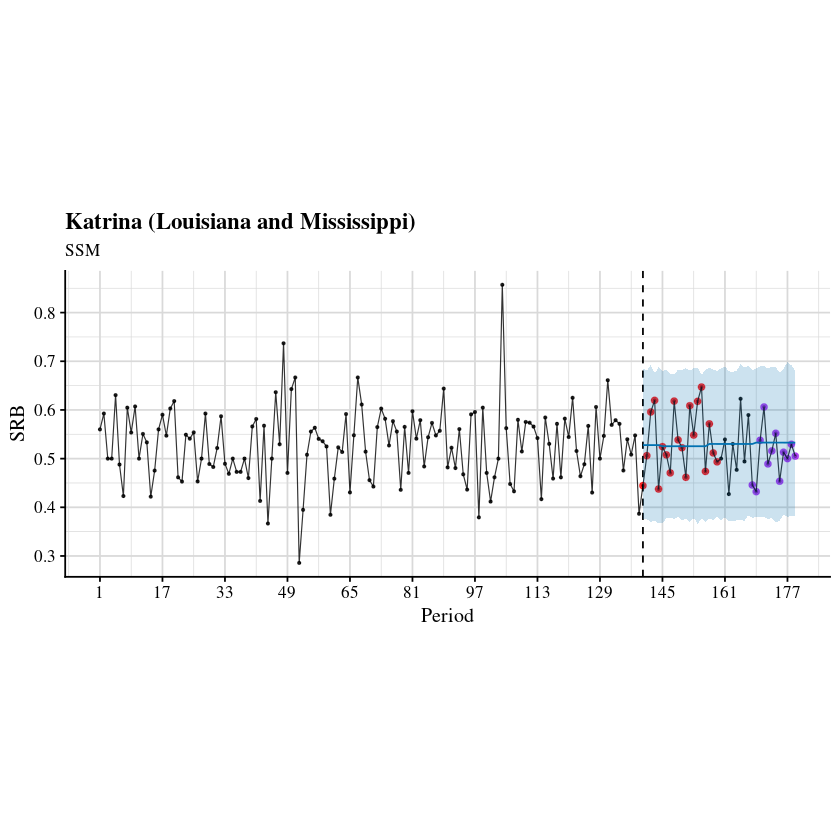

In [62]:
p_causal_katrina_wk_lams

## Virginia Tech (16 April, 2007)

In [63]:
.vtech <- as_date("2007-04-16")

In [64]:
dat_vtech_wk_all <- 
    dat %>%
    add_periods(
        start = .start, intv = `.vtech`, len = len, nperiod = nperiod
    )

Intervention on day 1567.
Residual = 6.


In [65]:
dat_vtech_wk_all$intv_period

[1] 225

In [66]:
df_vtech_wk_all <- 
    dat_vtech_wk_all$df %>%
    get_summarised_data()

In [67]:
df_vtech_wk_all

period,period_start,period_end,Count,Sum,y
<dbl>,<date>,<date>,<int>,<int>,<dbl>
1,2002-12-30,2003-01-05,504,1020,0.4941176
2,2003-01-06,2003-01-12,975,1885,0.5172414
3,2003-01-13,2003-01-19,1004,1907,0.5264814
4,2003-01-20,2003-01-26,991,1884,0.5260085
5,2003-01-27,2003-02-02,962,1795,0.5359331
6,2003-02-03,2003-02-09,1003,1942,0.5164779
7,2003-02-10,2003-02-16,994,1955,0.5084399
8,2003-02-17,2003-02-23,1015,1891,0.5367530
9,2003-02-24,2003-03-02,1005,2000,0.5025000


In [ ]:
df_vtech_wk_all %>%
    write_delim(
        path = str_c(basedir, "ts_vtech_wk_all.tsv"),
        delim = "\t"
    )

### All states

#### ARIMA

In [68]:
arima_vtech_wk_all <-
    df_vtech_wk_all %>%
    fit_arima(
        .period = dat_vtech_wk_all$intv_period,
        seasonal = TRUE,
        allowmean = TRUE,
        ic = "bic",
        nmodels = 500,
        max.order = 48,
        max.D = 12, 
        stepwise = TRUE,
        parallel = TRUE
    )

Warning message in auto.arima(., ...):
“Parallel computer is only implemented when stepwise=FALSE, the model will be fit in serial.”

In [69]:
arima_vtech_wk_all

Series: . 
ARIMA(1,1,1) 

Coefficients:
          ar1      ma1
      -0.0713  -0.9742
s.e.   0.0689   0.0153

sigma^2 estimated as 9.327e-05:  log likelihood=717.74
AIC=-1429.48   AICc=-1429.37   BIC=-1419.26

In [70]:
resfit_arima_vtech_wk_all <-
    lm(formula = arima_vtech_wk_all$residuals ~ 1)

In [71]:
bg_arima_vtech_wk_all <-
    resfit_arima_vtech_wk_all %>%
    checkresiduals(lag = 13, test = "BG", plot = FALSE)

In [72]:
print(bg_arima_vtech_wk_all)


	Breusch-Godfrey test for serial correlation of order up to 13

data:  Residuals
LM test = 12.099, df = 13, p-value = 0.5195



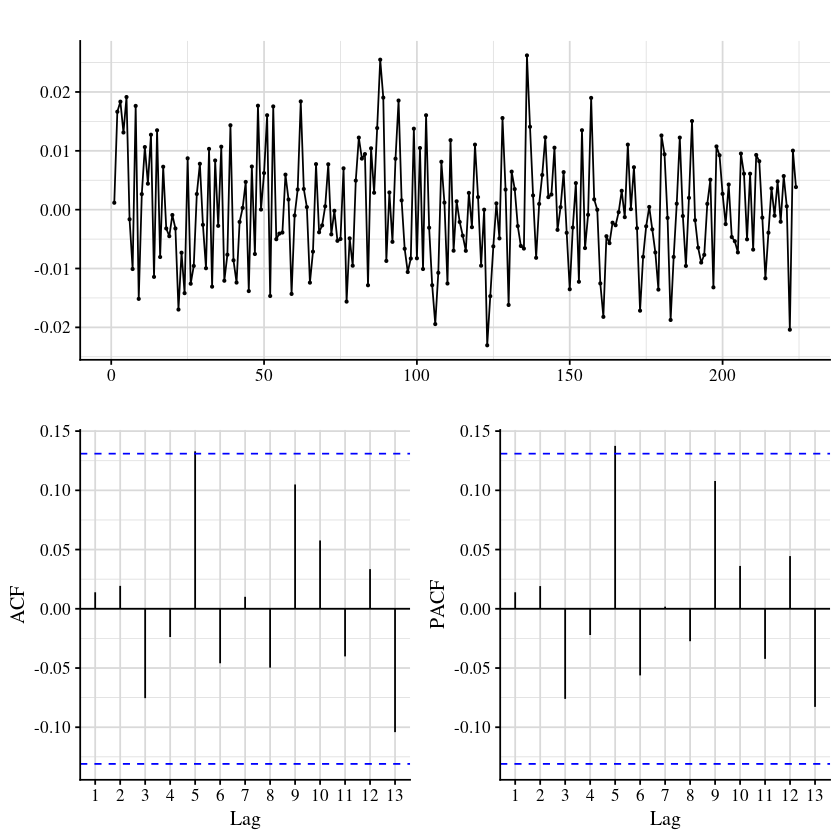

In [73]:
resfit_arima_vtech_wk_all %>%
    residuals() %>%
    ggtsdisplay(
        plot.type = c("partial"),
        lag.max = 13,
        theme = theme_cowplot(
            font_size = 12, font_family = 'serif'
        ) +
        background_grid(
            minor = 'xy'
        )
    )

In [74]:
pred_arima_vtech_wk_all <-
    arima_vtech_wk_all %>%
    get_arima_forecasts(
        df = df_vtech_wk_all,
        h = nperiod,
        level = 95
    )

Joining, by = "period"

In [75]:
pred_arima_vtech_wk_all

period,period_start,period_end,Count,Sum,y,yhat,yhat_lower,yhat_upper
<dbl>,<date>,<date>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,2002-12-30,2003-01-05,504,1020,0.4941176,NA,NA,NA
2,2003-01-06,2003-01-12,975,1885,0.5172414,NA,NA,NA
3,2003-01-13,2003-01-19,1004,1907,0.5264814,NA,NA,NA
4,2003-01-20,2003-01-26,991,1884,0.5260085,NA,NA,NA
5,2003-01-27,2003-02-02,962,1795,0.5359331,NA,NA,NA
6,2003-02-03,2003-02-09,1003,1942,0.5164779,NA,NA,NA
7,2003-02-10,2003-02-16,994,1955,0.5084399,NA,NA,NA
8,2003-02-17,2003-02-23,1015,1891,0.5367530,NA,NA,NA
9,2003-02-24,2003-03-02,1005,2000,0.5025000,NA,NA,NA


In [76]:
pred_arima_vtech_wk_all %>%
    dplyr::filter(
        period >= dat_vtech_wk_all$intv_period
    ) %>%
    dplyr::select(
        Period = period, SRB = y,
        `Lower 95%` = yhat_lower, `Upper 95%` = yhat_upper
    ) %>%
    xtable(
        auto = TRUE, digits = 4,
        caption = "10 period out-of-sample forecasts for Virginia Tech Shooting in all states"
    ) %>%
    print(
        include.rownames = FALSE,
        booktabs = TRUE
    )

% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Wed Apr  1 15:23:16 2020
\begin{table}[ht]
\centering
\begin{tabular}{rrrr}
  \toprule
Period & SRB & Lower 95\% & Upper 95\% \\ 
  \midrule
  225 & 0.5039 & 0.4943 & 0.5322 \\ 
    226 & 0.4977 & 0.4945 & 0.5324 \\ 
    227 & 0.5079 & 0.4945 & 0.5324 \\ 
    228 & 0.5089 & 0.4945 & 0.5324 \\ 
    229 & 0.5113 & 0.4945 & 0.5324 \\ 
    230 & 0.5104 & 0.4945 & 0.5324 \\ 
    231 & 0.5229 & 0.4944 & 0.5324 \\ 
    232 & 0.5141 & 0.4944 & 0.5324 \\ 
    233 & 0.5178 & 0.4944 & 0.5324 \\ 
    234 & 0.5067 & 0.4944 & 0.5324 \\ 
    235 & 0.5000 & 0.4944 & 0.5324 \\ 
    236 & 0.5140 & 0.4944 & 0.5324 \\ 
    237 & 0.5211 & 0.4944 & 0.5324 \\ 
    238 & 0.5159 & 0.4944 & 0.5324 \\ 
    239 & 0.5180 & 0.4944 & 0.5324 \\ 
    240 & 0.5129 & 0.4944 & 0.5325 \\ 
    241 & 0.5009 & 0.4944 & 0.5325 \\ 
    242 & 0.5128 & 0.4944 & 0.5325 \\ 
    243 & 0.5055 & 0.4944 & 0.5325 \\ 
    244 & 0.5016 & 0.4944 & 0.5325 \\ 
    245 & 0.5291 & 0

In [77]:
p_arima_vtech_wk_all <-
    pred_arima_vtech_wk_all %>%
    plot_pred(
        .period = dat_vtech_wk_all$intv_period,
        .title = "Virginia Tech Shooting (all states)"
    ) +
    labs(subtitle = "ARIMA")

In [78]:
p_arima_vtech_wk_all %>%
    cowplot::save_plot(
        filename = str_c(basedir, "plots/time_series/", "ts_wk_vtech_arima_all_states.pdf")
    )

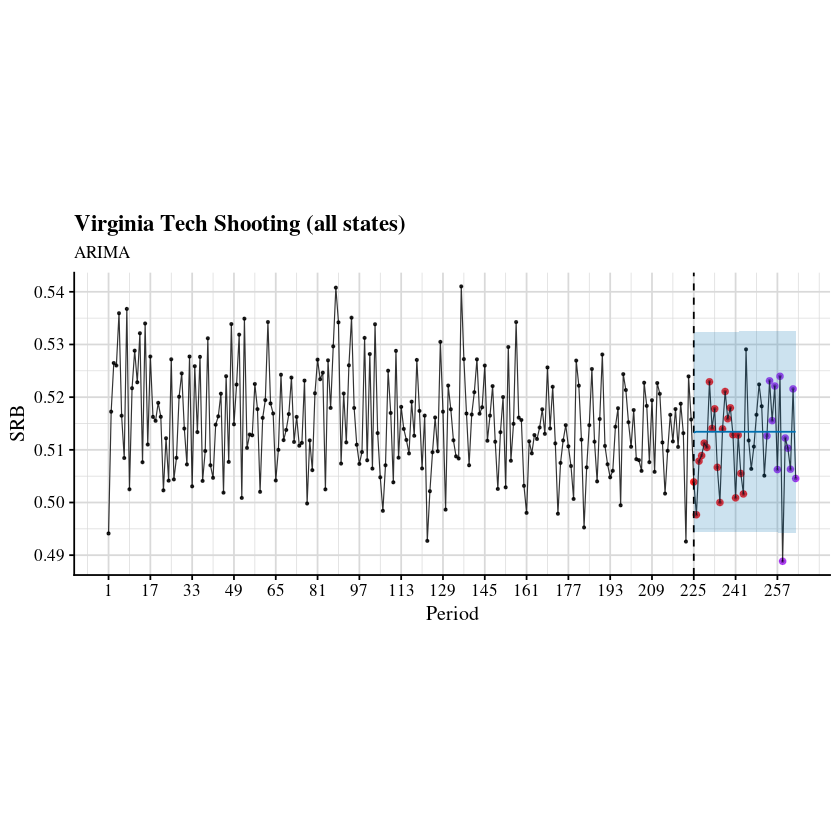

In [79]:
p_arima_vtech_wk_all

#### CausalImpact

In [80]:
bsts_vtech_all <-
    df_vtech_wk_all %>%
    get_ssm_causal(
        .intv = dat_vtech_wk_all$intv_period
    )

=-=-=-=-= Iteration 0 Wed Apr  1 15:23:17 2020 =-=-=-=-=
=-=-=-=-= Iteration 200 Wed Apr  1 15:23:17 2020 =-=-=-=-=
=-=-=-=-= Iteration 400 Wed Apr  1 15:23:18 2020 =-=-=-=-=
=-=-=-=-= Iteration 600 Wed Apr  1 15:23:18 2020 =-=-=-=-=
=-=-=-=-= Iteration 800 Wed Apr  1 15:23:19 2020 =-=-=-=-=
=-=-=-=-= Iteration 1000 Wed Apr  1 15:23:19 2020 =-=-=-=-=
=-=-=-=-= Iteration 1200 Wed Apr  1 15:23:20 2020 =-=-=-=-=
=-=-=-=-= Iteration 1400 Wed Apr  1 15:23:20 2020 =-=-=-=-=
=-=-=-=-= Iteration 1600 Wed Apr  1 15:23:21 2020 =-=-=-=-=
=-=-=-=-= Iteration 1800 Wed Apr  1 15:23:21 2020 =-=-=-=-=


In [81]:
causal_vtech_all <-
    df_vtech_wk_all %>%
    dplyr::filter(
        period >= dat_vtech_wk_all$intv_period
    ) %>%
    dplyr::pull(y) %>%
    CausalImpact(
        bsts.model = bsts_vtech_all$model,
        post.period.response = .
    )

In [82]:
df_causal_vtech_all <-
    causal_vtech_all$series %>%
    tk_tbl() %>%
    rowid_to_column(var = "Period")

Warning message in tk_tbl.zoo(.):
“Warning: No index to preserve. Object otherwise converted to tibble successfully.”

In [83]:
pred_causal_vtech_all <-
    df_causal_vtech_all %>%
    dplyr::select(
        period = Period,
        y = response,
        yhat = point.pred,
        yhat_lower = point.pred.lower,
        yhat_upper = point.pred.upper
    ) 

In [84]:
pred_causal_vtech_all %>%
    dplyr::filter(period >= dat_vtech_wk_all$intv_period) %>%
    dplyr::select(
        Period = period, SRB = y,
        `Lower 95%` = yhat_lower, `Upper 95%` = yhat_upper
    ) %>%
    xtable(
        auto = TRUE, digits = 4,
        caption = "10 period out-of-sample forecasts for Virginia Tech Shooting in all states"
    ) %>%
    print(
        include.rownames = FALSE,
        booktabs = TRUE
    )

% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Wed Apr  1 15:23:23 2020
\begin{table}[ht]
\centering
\begin{tabular}{rrrr}
  \toprule
Period & SRB & Lower 95\% & Upper 95\% \\ 
  \midrule
  225 & 0.5039 & 0.4935 & 0.5324 \\ 
    226 & 0.4977 & 0.4933 & 0.5323 \\ 
    227 & 0.5079 & 0.4929 & 0.5315 \\ 
    228 & 0.5089 & 0.4944 & 0.5311 \\ 
    229 & 0.5113 & 0.4958 & 0.5348 \\ 
    230 & 0.5104 & 0.4963 & 0.5349 \\ 
    231 & 0.5229 & 0.4975 & 0.5354 \\ 
    232 & 0.5141 & 0.4973 & 0.5350 \\ 
    233 & 0.5178 & 0.4951 & 0.5346 \\ 
    234 & 0.5067 & 0.4965 & 0.5349 \\ 
    235 & 0.5000 & 0.4970 & 0.5351 \\ 
    236 & 0.5140 & 0.4958 & 0.5348 \\ 
    237 & 0.5211 & 0.4972 & 0.5359 \\ 
    238 & 0.5159 & 0.4965 & 0.5370 \\ 
    239 & 0.5180 & 0.4966 & 0.5350 \\ 
    240 & 0.5129 & 0.4959 & 0.5344 \\ 
    241 & 0.5009 & 0.4956 & 0.5335 \\ 
    242 & 0.5128 & 0.4941 & 0.5333 \\ 
    243 & 0.5055 & 0.4945 & 0.5341 \\ 
    244 & 0.5016 & 0.4947 & 0.5329 \\ 
    245 & 0.5291 & 0

In [85]:
p_causal_vtech_all <-
    pred_causal_vtech_all %>%
    plot_pred(
        .period = dat_vtech_wk_all$intv_period,
        .title = "Virginia Tech Shooting (all states)"
    ) +
    labs(subtitle = "SSM")

In [86]:
p_causal_vtech_all %>%
    cowplot::save_plot(
        filename = str_c(basedir, "plots/time_series/", "ts_wk_vtech_ssm_all_states.pdf")
    )

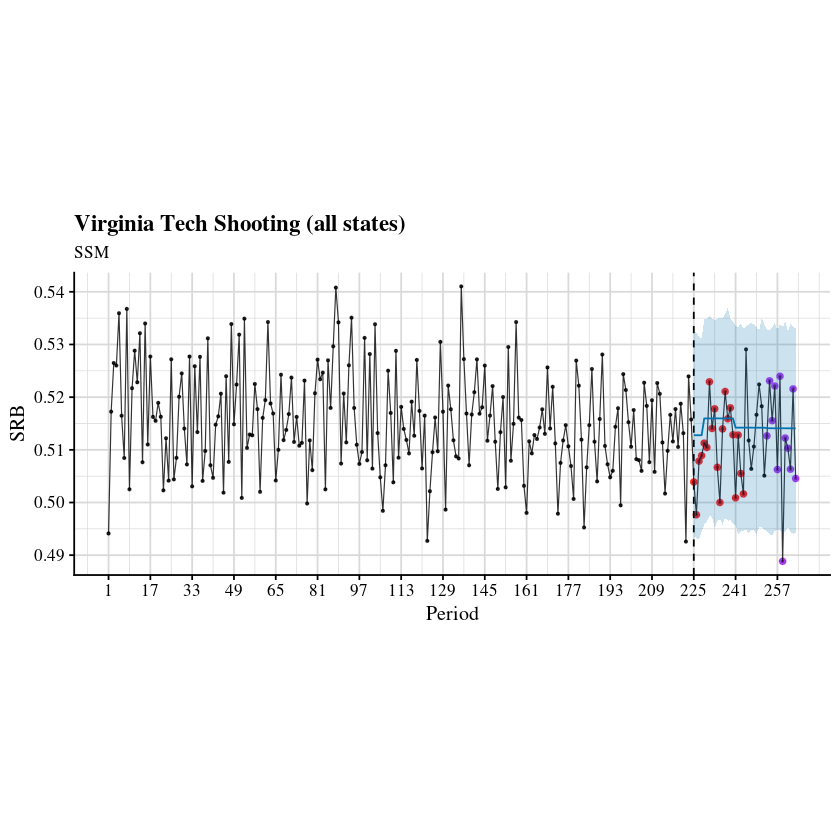

In [87]:
p_causal_vtech_all

### Adjacent states only

In [88]:
fips_adj <-
    read_table(
        file = str_c(basedir, "regression/FIPS_VA_adj.csv"),
        col_names = FALSE
    ) %>%
    pull()

Parsed with column specification:
cols(
  X1 = col_double()
)


In [89]:
dat_vtech_wk_adj <-
    list(
        df = dat_vtech_wk_all$df %>%
             dplyr::filter(FIPS %in% fips_adj),
        intv_period = dat_vtech_wk_all$intv_period
    )

In [90]:
df_vtech_wk_adj <-
    dat_vtech_wk_adj$df %>%
    get_summarised_data()

In [91]:
arima_vtech_wk_adj <-
    df_vtech_wk_adj %>%
    fit_arima(
        .period = dat_vtech_wk_adj$intv_period,
        seasonal = TRUE,
        allowmean = TRUE,
        ic = "bic",
        nmodels = 500,
        max.order = 48,
        max.D = 12,
        stepwise = TRUE,
        parallel = TRUE
    )

Warning message in auto.arima(., ...):
“Parallel computer is only implemented when stepwise=FALSE, the model will be fit in serial.”

In [92]:
arima_vtech_wk_adj

Series: . 
ARIMA(1,0,1) with non-zero mean 

Coefficients:
          ar1     ma1    mean
      -0.9847  0.9584  0.5164
s.e.   0.0261  0.0357  0.0020

sigma^2 estimated as 0.0008931:  log likelihood=469.87
AIC=-931.75   AICc=-931.57   BIC=-918.1

In [93]:
resfit_arima_vtech_wk_adj <-
    lm(formula = arima_vtech_wk_adj$residuals ~ 1)

In [94]:
bg_arima_vtech_wk_adj <-
    resfit_arima_vtech_wk_adj %>%
    checkresiduals(lag = 13, test = "BG", plot = FALSE)

In [95]:
print(bg_arima_vtech_wk_adj)


	Breusch-Godfrey test for serial correlation of order up to 13

data:  Residuals
LM test = 9.8208, df = 13, p-value = 0.7085



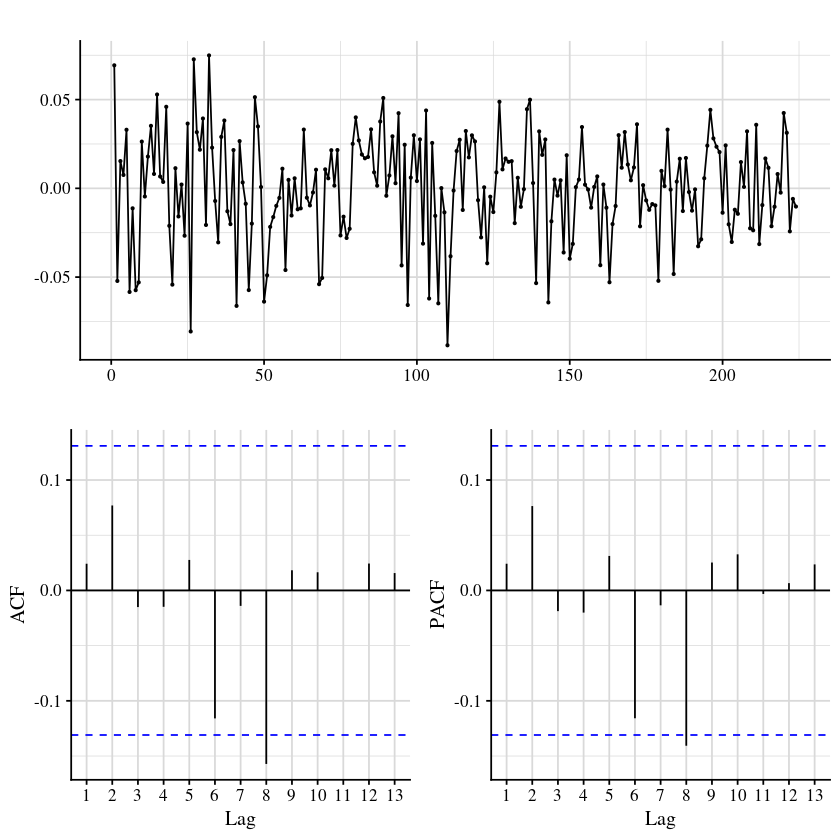

In [96]:
resfit_arima_vtech_wk_adj %>%
    residuals() %>%
    ggtsdisplay(
        plot.type = c("partial"),
        lag.max = 13,
        theme = theme_cowplot(
            font_size = 12, font_family = 'serif'
        ) +
        background_grid(
            minor = 'xy'
        )
    )

In [97]:
pred_arima_vtech_wk_adj <-
    arima_vtech_wk_adj %>%
    get_arima_forecasts(
        df = df_vtech_wk_adj,
        h = nperiod,
        level = 95
    )

Joining, by = "period"

In [98]:
pred_arima_vtech_wk_adj

period,period_start,period_end,Count,Sum,y,yhat,yhat_lower,yhat_upper
<dbl>,<date>,<date>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,2002-12-30,2003-01-05,61,104,0.5865385,NA,NA,NA
2,2003-01-06,2003-01-12,93,202,0.4603960,NA,NA,NA
3,2003-01-13,2003-01-19,100,186,0.5376344,NA,NA,NA
4,2003-01-20,2003-01-26,102,197,0.5177665,NA,NA,NA
5,2003-01-27,2003-02-02,110,198,0.5555556,NA,NA,NA
6,2003-02-03,2003-02-09,82,182,0.4505495,NA,NA,NA
7,2003-02-10,2003-02-16,107,208,0.5144231,NA,NA,NA
8,2003-02-17,2003-02-23,81,180,0.4500000,NA,NA,NA
9,2003-02-24,2003-03-02,100,211,0.4739336,NA,NA,NA


In [99]:
pred_arima_vtech_wk_adj %>%
    dplyr::filter(
        period >= dat_vtech_wk_adj$intv_period
    ) %>%
    dplyr::select(
        Period = period, SRB = y,
        `Lower 95%` = yhat_lower, `Upper 95%` = yhat_upper
    ) %>%
    xtable(
        auto = TRUE, digits = 4,
        caption = "10 period out-of-sample forecasts for Virginia Tech Shooting in adjacent states"
    ) %>%
    print(
        include.rownames = FALSE,
        booktabs = TRUE
    )

% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Wed Apr  1 15:23:25 2020
\begin{table}[ht]
\centering
\begin{tabular}{rrrr}
  \toprule
Period & SRB & Lower 95\% & Upper 95\% \\ 
  \midrule
  225 & 0.5134 & 0.4567 & 0.5739 \\ 
    226 & 0.4908 & 0.4589 & 0.5761 \\ 
    227 & 0.5212 & 0.4567 & 0.5739 \\ 
    228 & 0.5179 & 0.4589 & 0.5761 \\ 
    229 & 0.5261 & 0.4567 & 0.5740 \\ 
    230 & 0.5322 & 0.4588 & 0.5761 \\ 
    231 & 0.5280 & 0.4567 & 0.5741 \\ 
    232 & 0.4955 & 0.4587 & 0.5761 \\ 
    233 & 0.4822 & 0.4567 & 0.5741 \\ 
    234 & 0.4647 & 0.4587 & 0.5761 \\ 
    235 & 0.5406 & 0.4567 & 0.5742 \\ 
    236 & 0.5223 & 0.4586 & 0.5761 \\ 
    237 & 0.5150 & 0.4567 & 0.5743 \\ 
    238 & 0.5421 & 0.4585 & 0.5761 \\ 
    239 & 0.5231 & 0.4567 & 0.5743 \\ 
    240 & 0.5322 & 0.4585 & 0.5761 \\ 
    241 & 0.5143 & 0.4567 & 0.5744 \\ 
    242 & 0.5197 & 0.4584 & 0.5761 \\ 
    243 & 0.5465 & 0.4567 & 0.5744 \\ 
    244 & 0.5487 & 0.4584 & 0.5761 \\ 
    245 & 0.5049 & 0

In [100]:
p_arima_vtech_wk_adj <-
    pred_arima_vtech_wk_adj %>%
    plot_pred(
        .period = dat_vtech_wk_adj$intv_period,
        .title = "Virginia Tech Shooting (adjacent states only)"
    ) +
    labs(subtitle = "ARIMA")

In [101]:
p_arima_vtech_wk_adj %>%
    cowplot::save_plot(
        filename = str_c(basedir, "plots/time_series/", "ts_wk_vtech_arima_adjacent.pdf")
    )

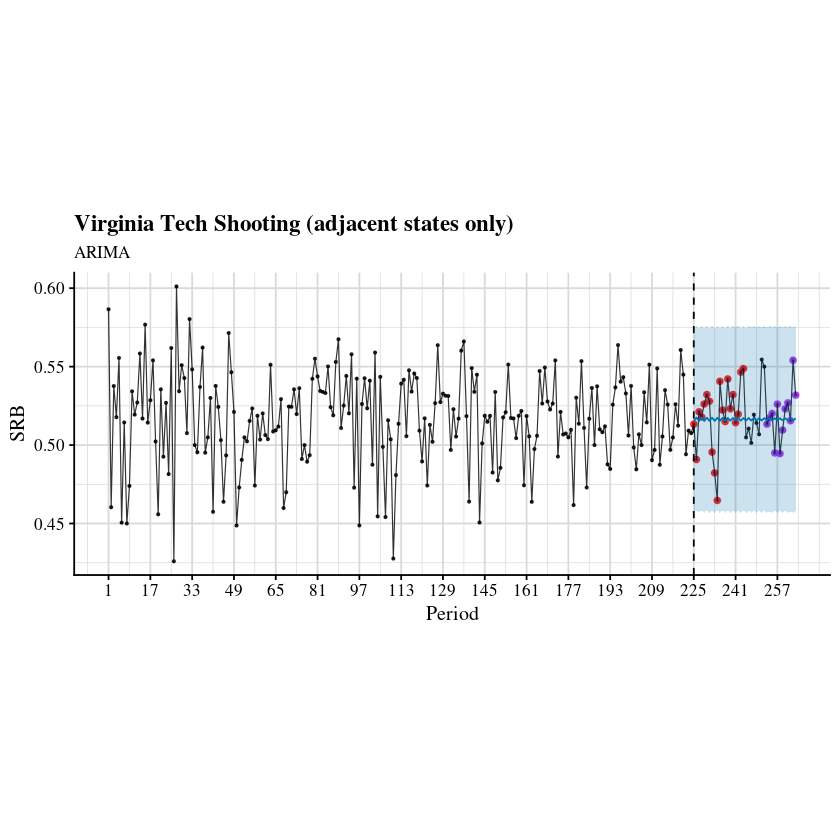

In [102]:
p_arima_vtech_wk_adj

#### CausalImpact

In [103]:
bsts_vtech_adj <-
    df_vtech_wk_adj %>%
    get_ssm_causal(
        .intv = dat_vtech_wk_adj$intv_period
    )

=-=-=-=-= Iteration 0 Wed Apr  1 15:23:26 2020 =-=-=-=-=
=-=-=-=-= Iteration 200 Wed Apr  1 15:23:26 2020 =-=-=-=-=
=-=-=-=-= Iteration 400 Wed Apr  1 15:23:27 2020 =-=-=-=-=
=-=-=-=-= Iteration 600 Wed Apr  1 15:23:27 2020 =-=-=-=-=
=-=-=-=-= Iteration 800 Wed Apr  1 15:23:28 2020 =-=-=-=-=
=-=-=-=-= Iteration 1000 Wed Apr  1 15:23:28 2020 =-=-=-=-=
=-=-=-=-= Iteration 1200 Wed Apr  1 15:23:29 2020 =-=-=-=-=
=-=-=-=-= Iteration 1400 Wed Apr  1 15:23:29 2020 =-=-=-=-=
=-=-=-=-= Iteration 1600 Wed Apr  1 15:23:30 2020 =-=-=-=-=
=-=-=-=-= Iteration 1800 Wed Apr  1 15:23:30 2020 =-=-=-=-=


In [104]:
causal_vtech_adj <-
    df_vtech_wk_adj %>%
    dplyr::filter(
        period >= dat_vtech_wk_adj$intv_period
    ) %>%
    dplyr::pull(y) %>%
    CausalImpact(
        bsts.model = bsts_vtech_adj$model,
        post.period.response = .
    )

In [105]:
df_causal_vtech_adj <-
    causal_vtech_adj$series %>%
    tk_tbl() %>%
    rowid_to_column(var = "Period")

Warning message in tk_tbl.zoo(.):
“Warning: No index to preserve. Object otherwise converted to tibble successfully.”

In [106]:
pred_causal_vtech_adj <-
    df_causal_vtech_adj %>%
    dplyr::select(
        period = Period,
        y = response,
        yhat = point.pred,
        yhat_lower = point.pred.lower,
        yhat_upper = point.pred.upper
    ) 

In [107]:
pred_causal_vtech_adj %>%
    dplyr::filter(period >= dat_vtech_wk_adj$intv_period) %>%
    dplyr::select(
        Period = period, SRB = y,
        `Lower 95%` = yhat_lower, `Upper 95%` = yhat_upper
    ) %>%
    xtable(
        auto = TRUE, digits = 4,
        caption = "10 period out-of-sample forecasts for Virginia Tech Shooting in adjacent states"
    ) %>%
    print(
        include.rownames = FALSE,
        booktabs = TRUE
    )

% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Wed Apr  1 15:23:31 2020
\begin{table}[ht]
\centering
\begin{tabular}{rrrr}
  \toprule
Period & SRB & Lower 95\% & Upper 95\% \\ 
  \midrule
  225 & 0.5134 & 0.4620 & 0.5814 \\ 
    226 & 0.4908 & 0.4606 & 0.5813 \\ 
    227 & 0.5212 & 0.4608 & 0.5837 \\ 
    228 & 0.5179 & 0.4634 & 0.5796 \\ 
    229 & 0.5261 & 0.4593 & 0.5801 \\ 
    230 & 0.5322 & 0.4578 & 0.5779 \\ 
    231 & 0.5280 & 0.4613 & 0.5769 \\ 
    232 & 0.4955 & 0.4600 & 0.5823 \\ 
    233 & 0.4822 & 0.4618 & 0.5800 \\ 
    234 & 0.4647 & 0.4615 & 0.5792 \\ 
    235 & 0.5406 & 0.4617 & 0.5794 \\ 
    236 & 0.5223 & 0.4589 & 0.5805 \\ 
    237 & 0.5150 & 0.4624 & 0.5755 \\ 
    238 & 0.5421 & 0.4620 & 0.5826 \\ 
    239 & 0.5231 & 0.4607 & 0.5810 \\ 
    240 & 0.5322 & 0.4599 & 0.5786 \\ 
    241 & 0.5143 & 0.4506 & 0.5728 \\ 
    242 & 0.5197 & 0.4516 & 0.5732 \\ 
    243 & 0.5465 & 0.4504 & 0.5720 \\ 
    244 & 0.5487 & 0.4516 & 0.5714 \\ 
    245 & 0.5049 & 0

In [108]:
p_causal_vtech_adj <-
    pred_causal_vtech_adj %>%
    plot_pred(
        .period = dat_vtech_wk_adj$intv_period,
        .title = "Virginia Tech Shooting (adjacent states only)"
    ) +
    labs(subtitle = "SSM")

In [109]:
p_causal_vtech_adj %>%
    cowplot::save_plot(
        filename = str_c(basedir, "plots/time_series/", "ts_wk_vtech_ssm_adjacent.pdf")
    )

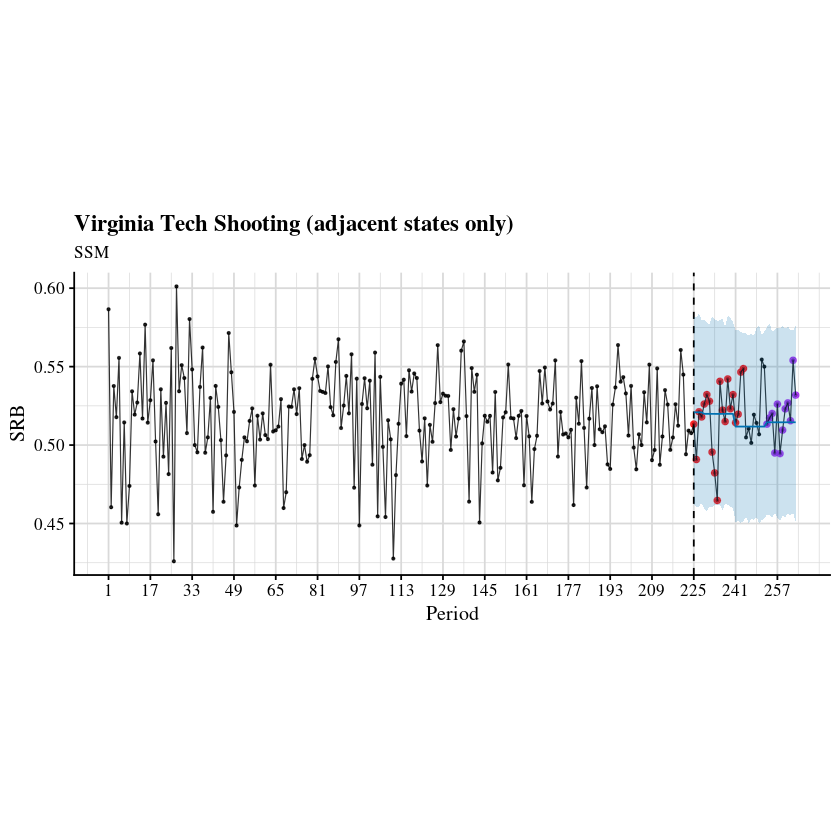

In [110]:
p_causal_vtech_adj